### Пример (данные оттока с 5 занятия)

In [ ]:
data = "/content/cmc.data"

In [ ]:
!pip install shap

In [ ]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
features = ['Wifes age', 'Wifes education', 'Husband education', 'Number of children', 'Wifes religion', 'Wife now working', 'Husband occupation', 'Living index', 'Media exposure', 'Contraceptive method']
df = pd.read_csv(data)
df.columns = features
df.head(3)

,Wifes age,Wifes education,Husband education,Number of children,Wifes religion,Wife now working,Husband occupation,Living index,Media exposure,Contraceptive method
0,45,1,3,10,1,1,3,4,0,1
1,43,2,3,7,1,1,3,4,0,1
2,42,3,2,9,1,1,3,3,0,1


In [ ]:
df.describe()

,Wifes age,Wifes education,Husband education,Number of children,Wifes religion,Wife now working,Husband occupation,Living index,Media exposure,Contraceptive method
count,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,32.544158,2.959239,3.430027,3.261549,0.850543,0.749321,2.137908,3.133832,0.074049,1.920516
std,8.227027,1.015031,0.816549,2.359341,0.356659,0.433552,0.865144,0.976486,0.261939,0.876345
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000
75%,39.000000,4.000000,4.000000,4.250000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000
max,49.000000,4.000000,4.000000,16.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000


In [ ]:
bins = {2: 0, 3: 0}
df['Contraceptive method'] = df['Contraceptive method'].replace(bins)

In [ ]:
df['Contraceptive method'].describe()

count    1472.000000
mean        0.426630
std         0.494756
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Contraceptive method, dtype: float64

In [ ]:
from sys import prefix
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[feature_to_encode], prefix = feature_to_encode)
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

In [ ]:
cat_features = ['Wifes education', 'Husband education', 'Husband occupation', 'Living index']
for el in cat_features:
  df = encode_and_bind(df, el)

In [ ]:
df.head()

,Wifes age,Number of children,Wifes religion,Wife now working,Media exposure,Contraceptive method,Wifes education_1,Wifes education_2,Wifes education_3,Wifes education_4,Husband education_1,Husband education_2,Husband education_3,Husband education_4,Husband occupation_1,Husband occupation_2,Husband occupation_3,Husband occupation_4,Living index_1,Living index_2,Living index_3,Living index_4
0,45,10,1,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1,43,7,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
2,42,9,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
3,36,8,1,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
4,19,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0


In [ ]:
X = df.drop(columns = 'Contraceptive method')

In [ ]:
y = df['Contraceptive method']

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
grad = GradientBoostingClassifier()

In [ ]:
model = grad.fit(X_train, y_train)

In [ ]:
!pip install Javascript

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

По графику видно, что чем выше уровень жизни семьи, тем больше вероятность использования контрацепции, так же положительно сказывается среднее или высшее образование и наличие детей. Меньше пользуются контрацепцией женщины, исповедующие ислам.


График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). 

- Цвет точки - это значение признака
- То, насколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
- То, насколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад

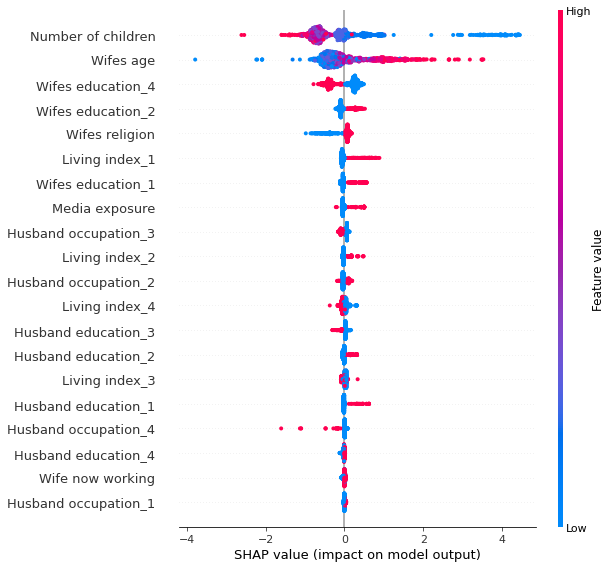

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Чем больше детей, тем больше люди предохраняются, чем выше возраст женщины, тем меньше используется контрацепция, женщины с высшим образованием предохраняются чаще, чем те, что такового не имеют, мусульманки не предохраняются.

Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Можно даже просто взять средние значения SHAP для каждого признака

In [ ]:
fi = pd.DataFrame({'feature_importance': model.feature_importances_,
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'],
                                                           ascending=False)

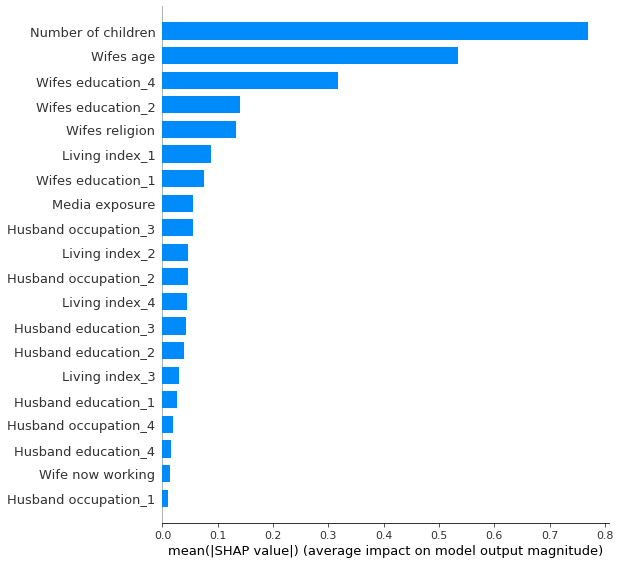

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")